# Summary

## How to set up Jupyter Notebook on your terminal:

* 1) Open up your terminal interface - this is where you'll be entering most of the following commands
* 2) initialise the terminal by typing:
```bash
gcc
```
* 3) install the command line tools
* 4) install Mac Hombrew by going to google and typing "docs.brew.sh", this should open up the Homebrew webpage
* 5) search up and install python on H.B. (Homebrew) - this is the coding language we will be using
* 6) install the virtual environment with H.B.
* 7) go back to the terminal and type:
```bash
python3 -m venv ~/Documents/projects/venv
```
* 8) now activate the virtual environment by typing these commands into the console:
```bash
cd ~/Documents/projects
```
```bash
source venv/bin/activate
```
* 9) now install the interactive notebook "Jupyter Notebook" by typing
```bash
python -m install jupyter
```
```bash
python -m ipykernel install --name=venv
```
* 10) now install scanpy by typing:
```bash
pip install scanpy
```
* 11) install leiden:
```bash
pip install leidenalg
```
* 12)  install numpy :
```bash
pip install numpy
```
* 13) install pandas:
```bash
pip install pandas
```
* 14) finally, start jupyter notebook by typing this into the console:
```bash
jupyter notebook
```
* 15) if you want to deactivate your virtual environment, type this into the console:
```bash
deactivate
```

## Preprocessing and clustering 3k PBMCs


In [1]:

import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3

sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor = "white")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7


In [3]:
results_file = "write/pbmc3k.h5ad"

In [4]:
adata = sc.read_10x_mtx(
"filtered_gene_bc_matrices/hg19/",
    var_names = "gene_symbols",
    cache = True
)

... reading from cache file cache/filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### This shows the genes with the highest fraction of counts in each cell, across all cells 

normalizing counts per cell
    finished (0:00:00)


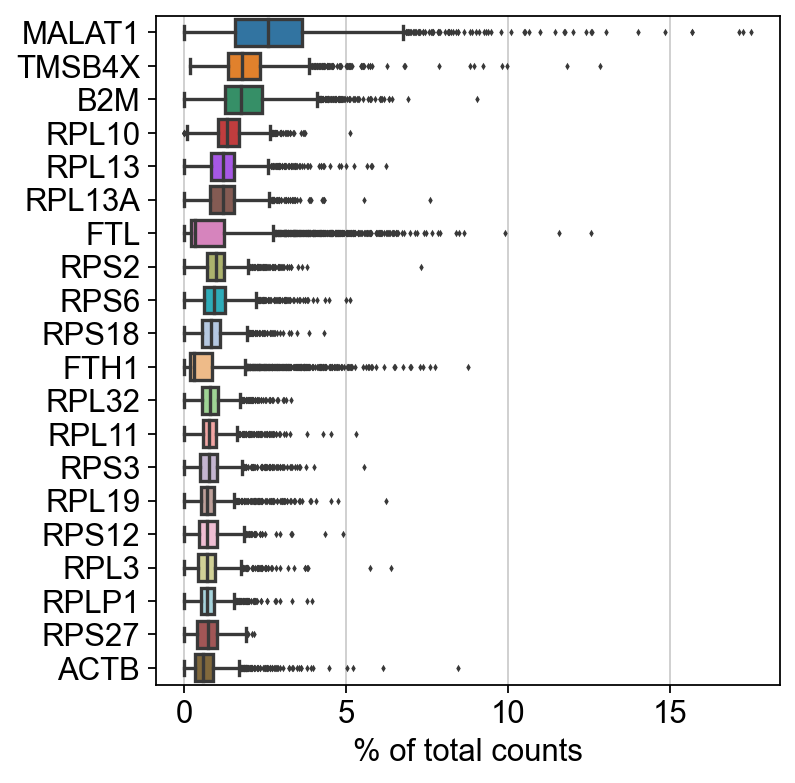

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 19024 genes that are detected in less than 3 cells


###  Filtered cell outliers based on genes expressed and counts

In [9]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], percent_top = None, log1p = False, inplace = True)

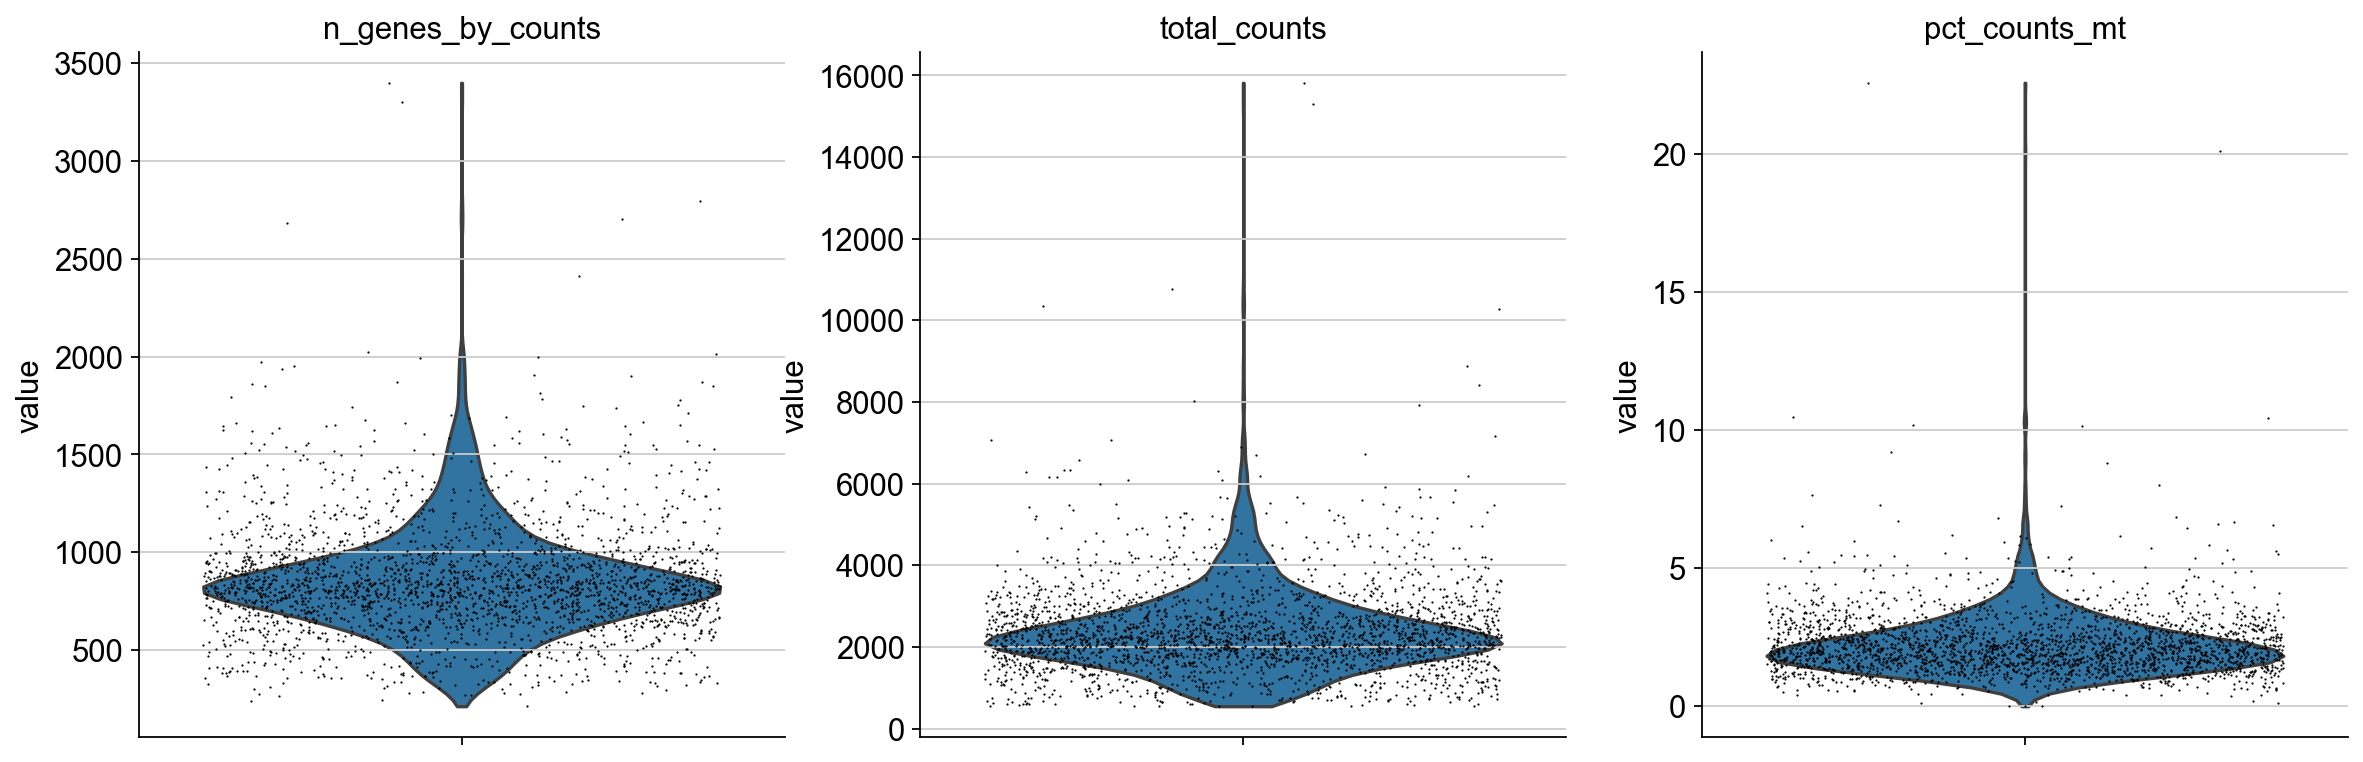

In [10]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter = 0.4, multi_panel = True)

##  Violin plot measuring:

* the number of genes expressed in the count matrix
* total counts per cell
* the percentage of counts in mitochondrial genes



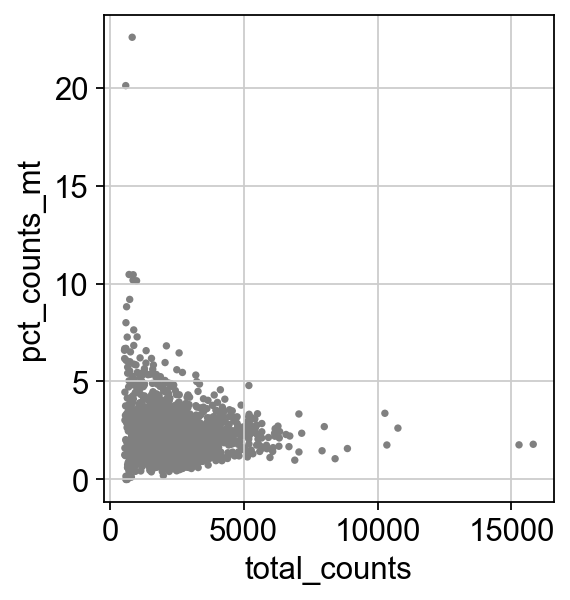

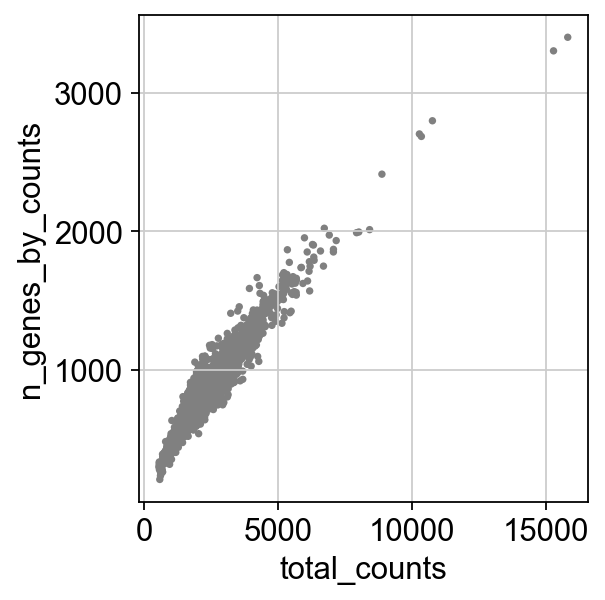

In [11]:
sc.pl.scatter(adata, x = "total_counts", y = "pct_counts_mt")
sc.pl.scatter(adata, x = "total_counts", y = "n_genes_by_counts")

### Removing cells thats have too many mitochondrial genes expressed or too many counts by slicing the AnnData object

In [12]:
adata = adata[adata.obs.n_genes_by_counts <2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

### Manipulate data so that counts become comparable amongst cells

In [13]:
sc.pp.normalize_total(adata, target_sum = 1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Logarithmize the data so we can gather more from a graph

In [14]:
sc.pp.log1p(adata)
#np.log1p(adata.X)

### Identify highly-variable genes

In [15]:
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

extracting highly variable genes


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


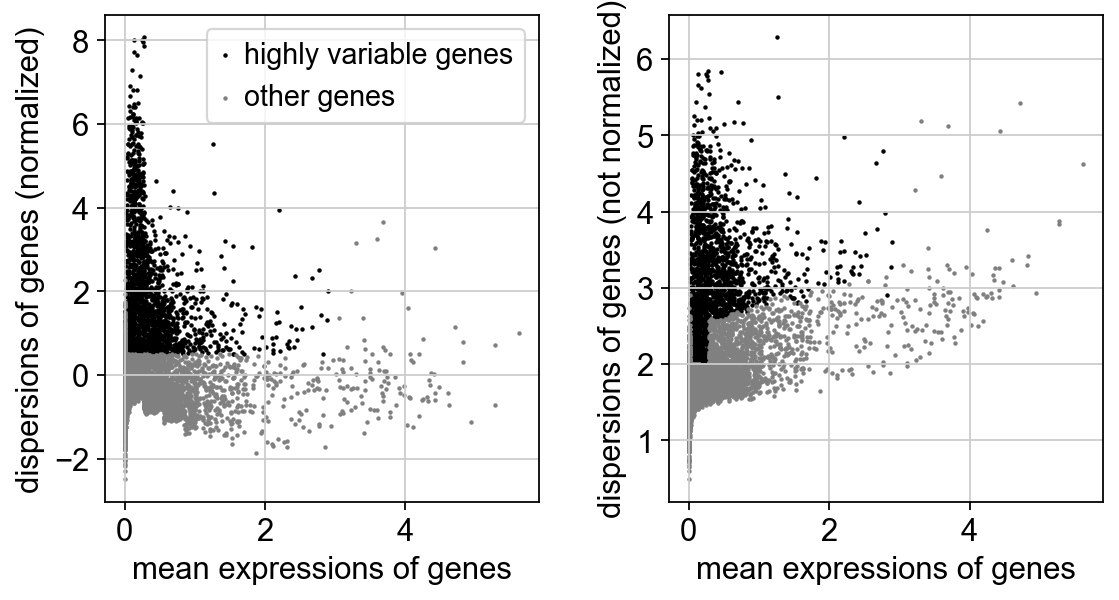

In [16]:
sc.pl.highly_variable_genes(adata)


### Slice the data so what's left is just the highly-variable genes

In [17]:
adata = adata[:, adata.var.highly_variable]

### Regress out the effects of total count per cell and the percentage of mitochondrial genes expressed then scale said data to unit variance

In [18]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


### Scale each gene to unit variance. Remove values exceeding a standard devation of 10 as if they do, they're most likely sickly cells

In [19]:
sc.pp.scale(adata, max_value = 10)

## Principle Component Analysis (Reducing Dimensionality)

### Denoise the data by using PCA (Principle Component Analysis) to focus on the main axes of variation

In [20]:
sc.tl.pca(adata, svd_solver = "arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


### Create a colour co-ordinated scatter graph of the values

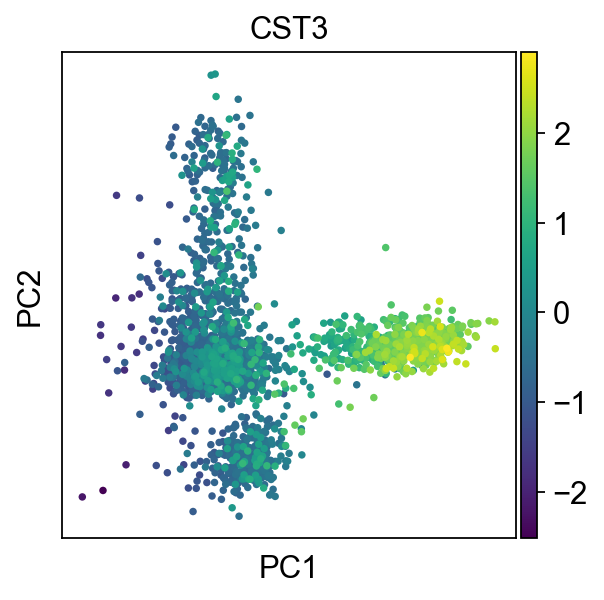

In [21]:
sc.pl.pca(adata, color = "CST3")

### Inspect the contrabution of single PCs to the total variance in data. This will tell us about how many PCs we should consider in order to compute the neighbouhood

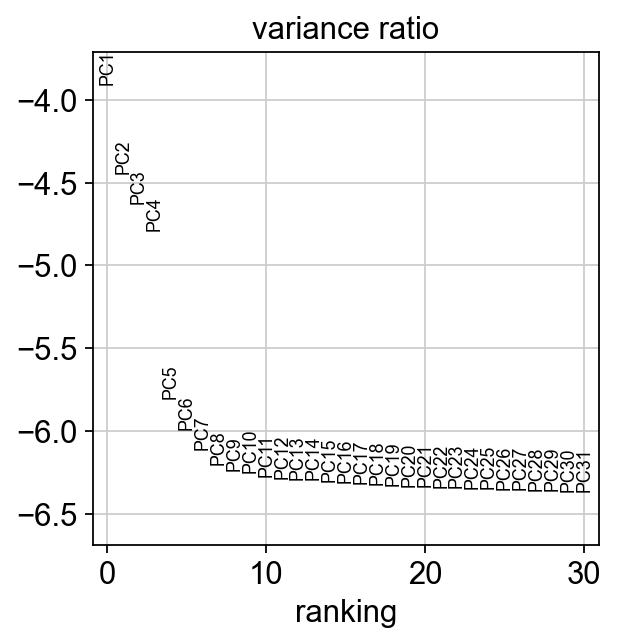

In [22]:
sc.pl.pca_variance_ratio(adata, log = True)

## Save the result

In [23]:
adata.write(results_file)

In [24]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighbourhood graph

### Now we will compute the graph using our PCA representation of the data array (matrix). We will use the following values used below

In [25]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighbourhood graph

### Here we will embed the graph into two dimensions using UMAP

In [26]:
## run leiden before 

In [27]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [28]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot = False)
sc.tl.umap(adata, init_pos = "paga")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


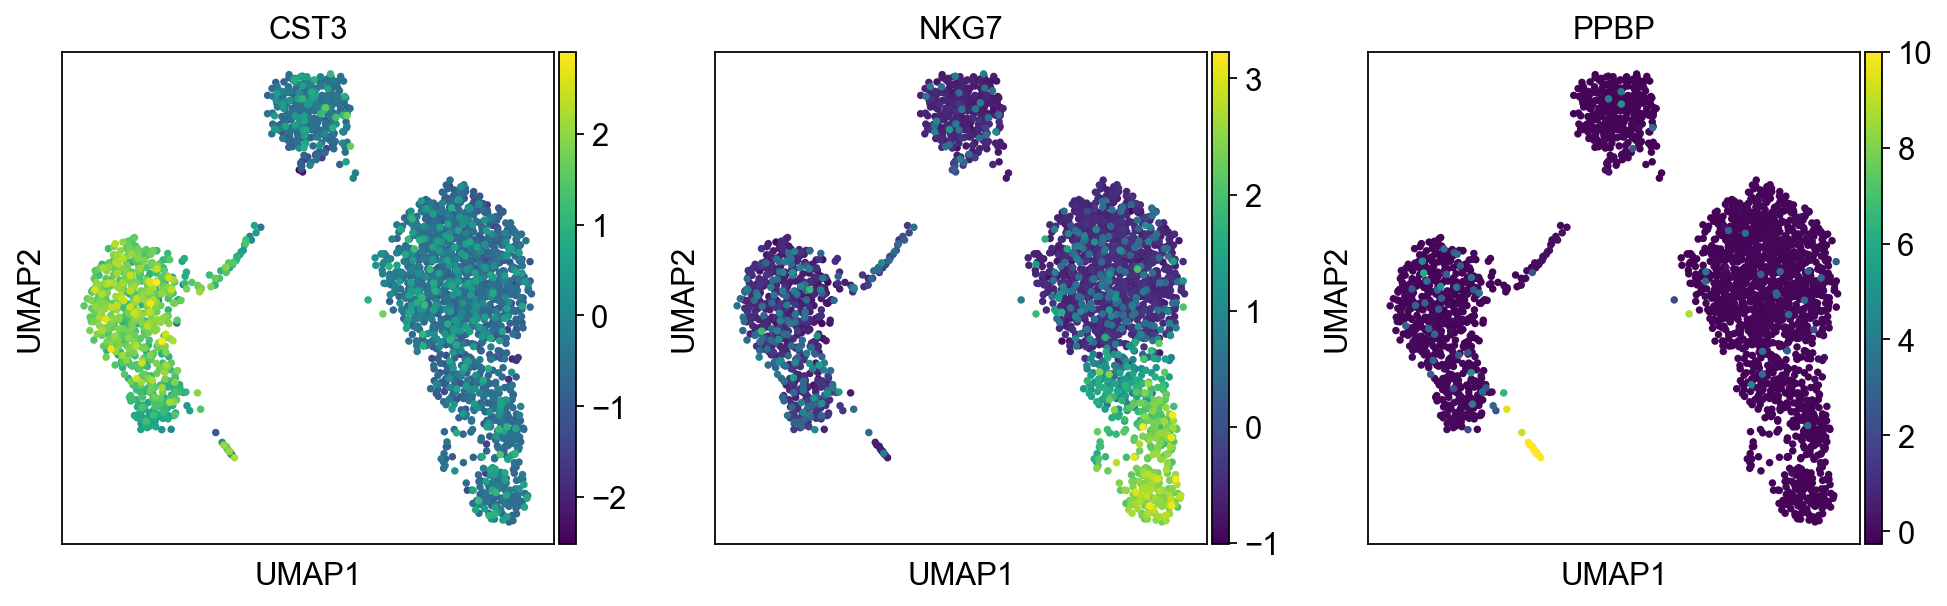

In [30]:
sc.pl.umap(adata, color = ["CST3", "NKG7", "PPBP"])

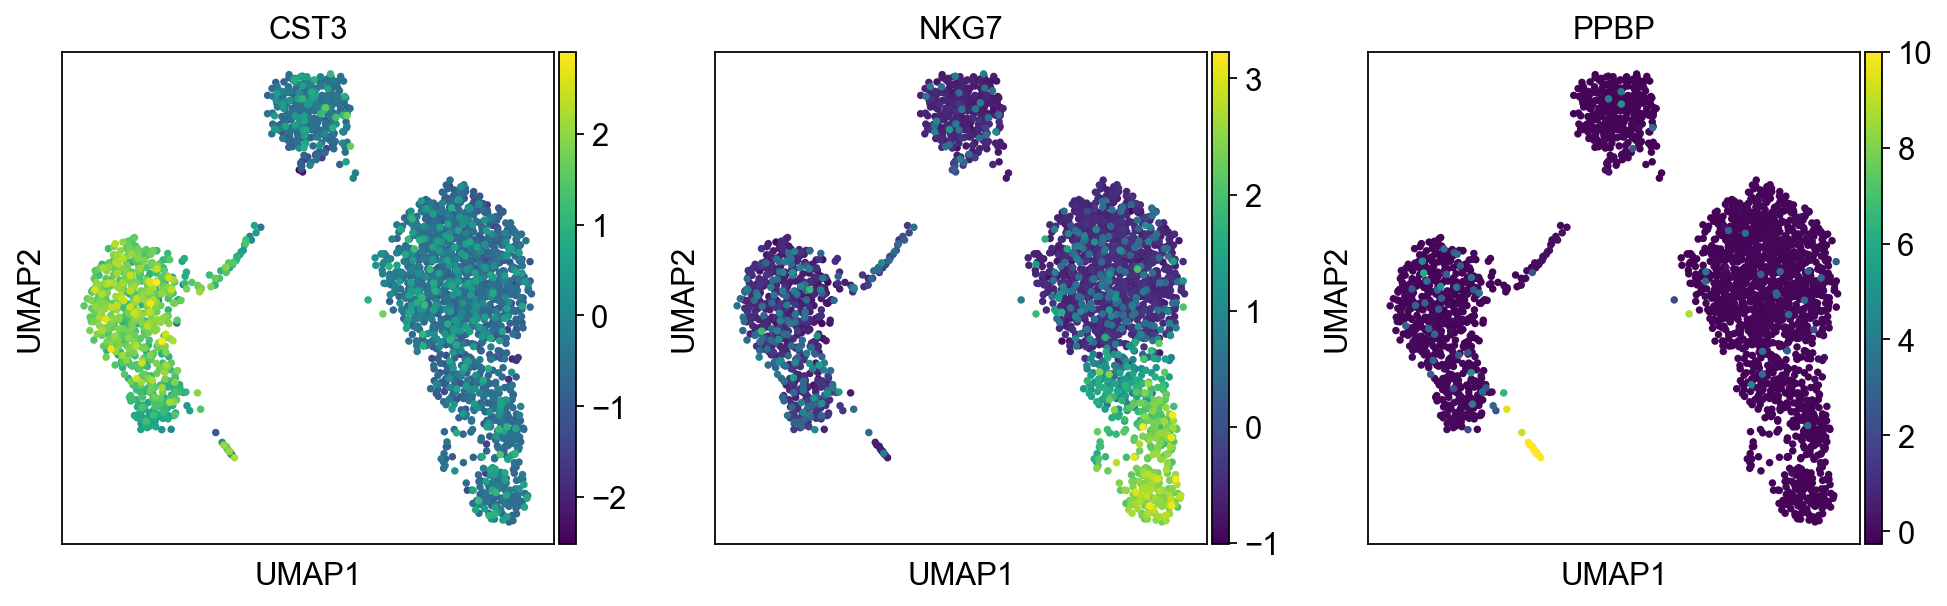

In [31]:
sc.pl.umap(adata, color = ["CST3", "NKG7", "PPBP"], use_raw = False)

/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


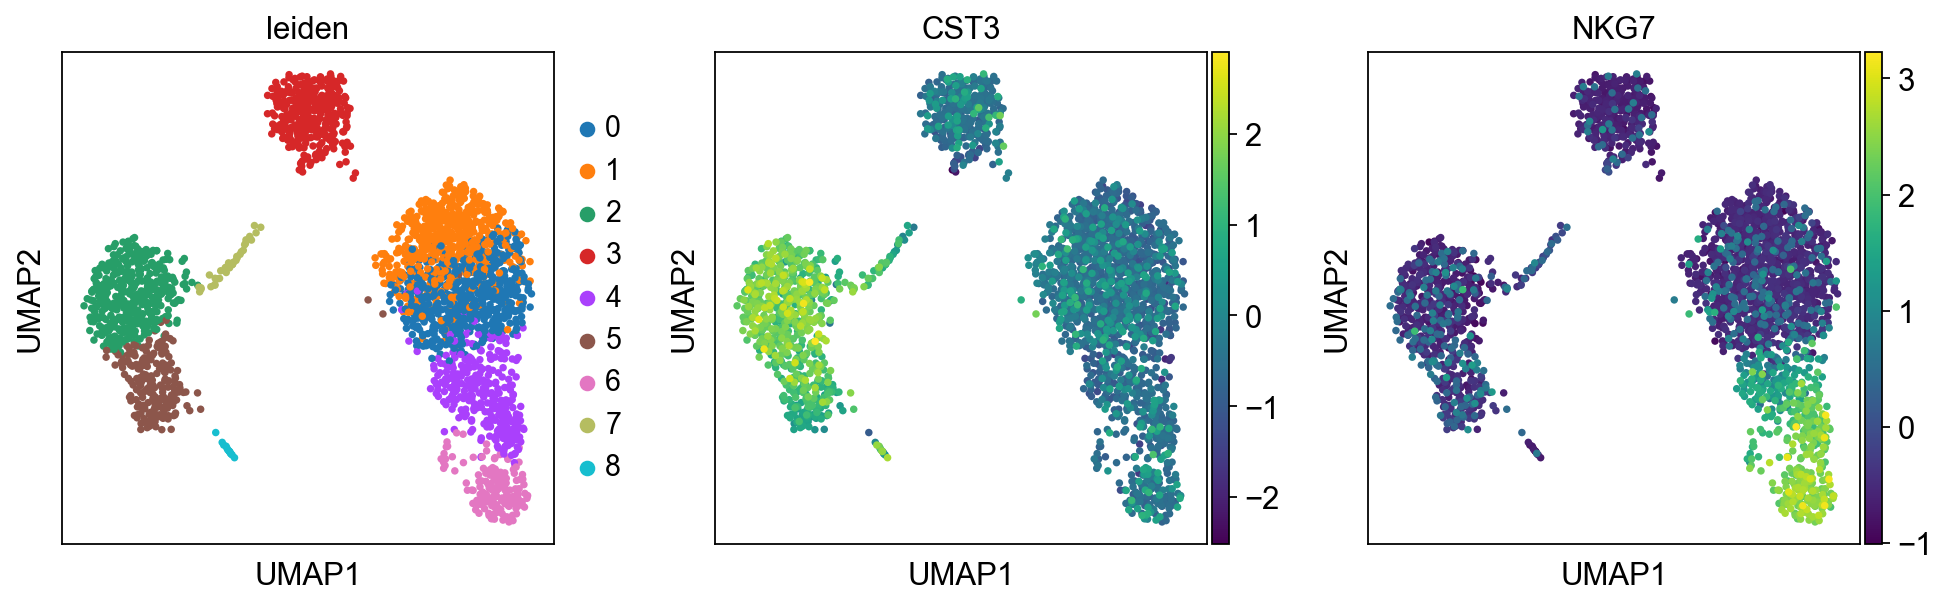

In [32]:
sc.pl.umap(adata, color = ["leiden", "CST3", "NKG7"])

In [33]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: inv

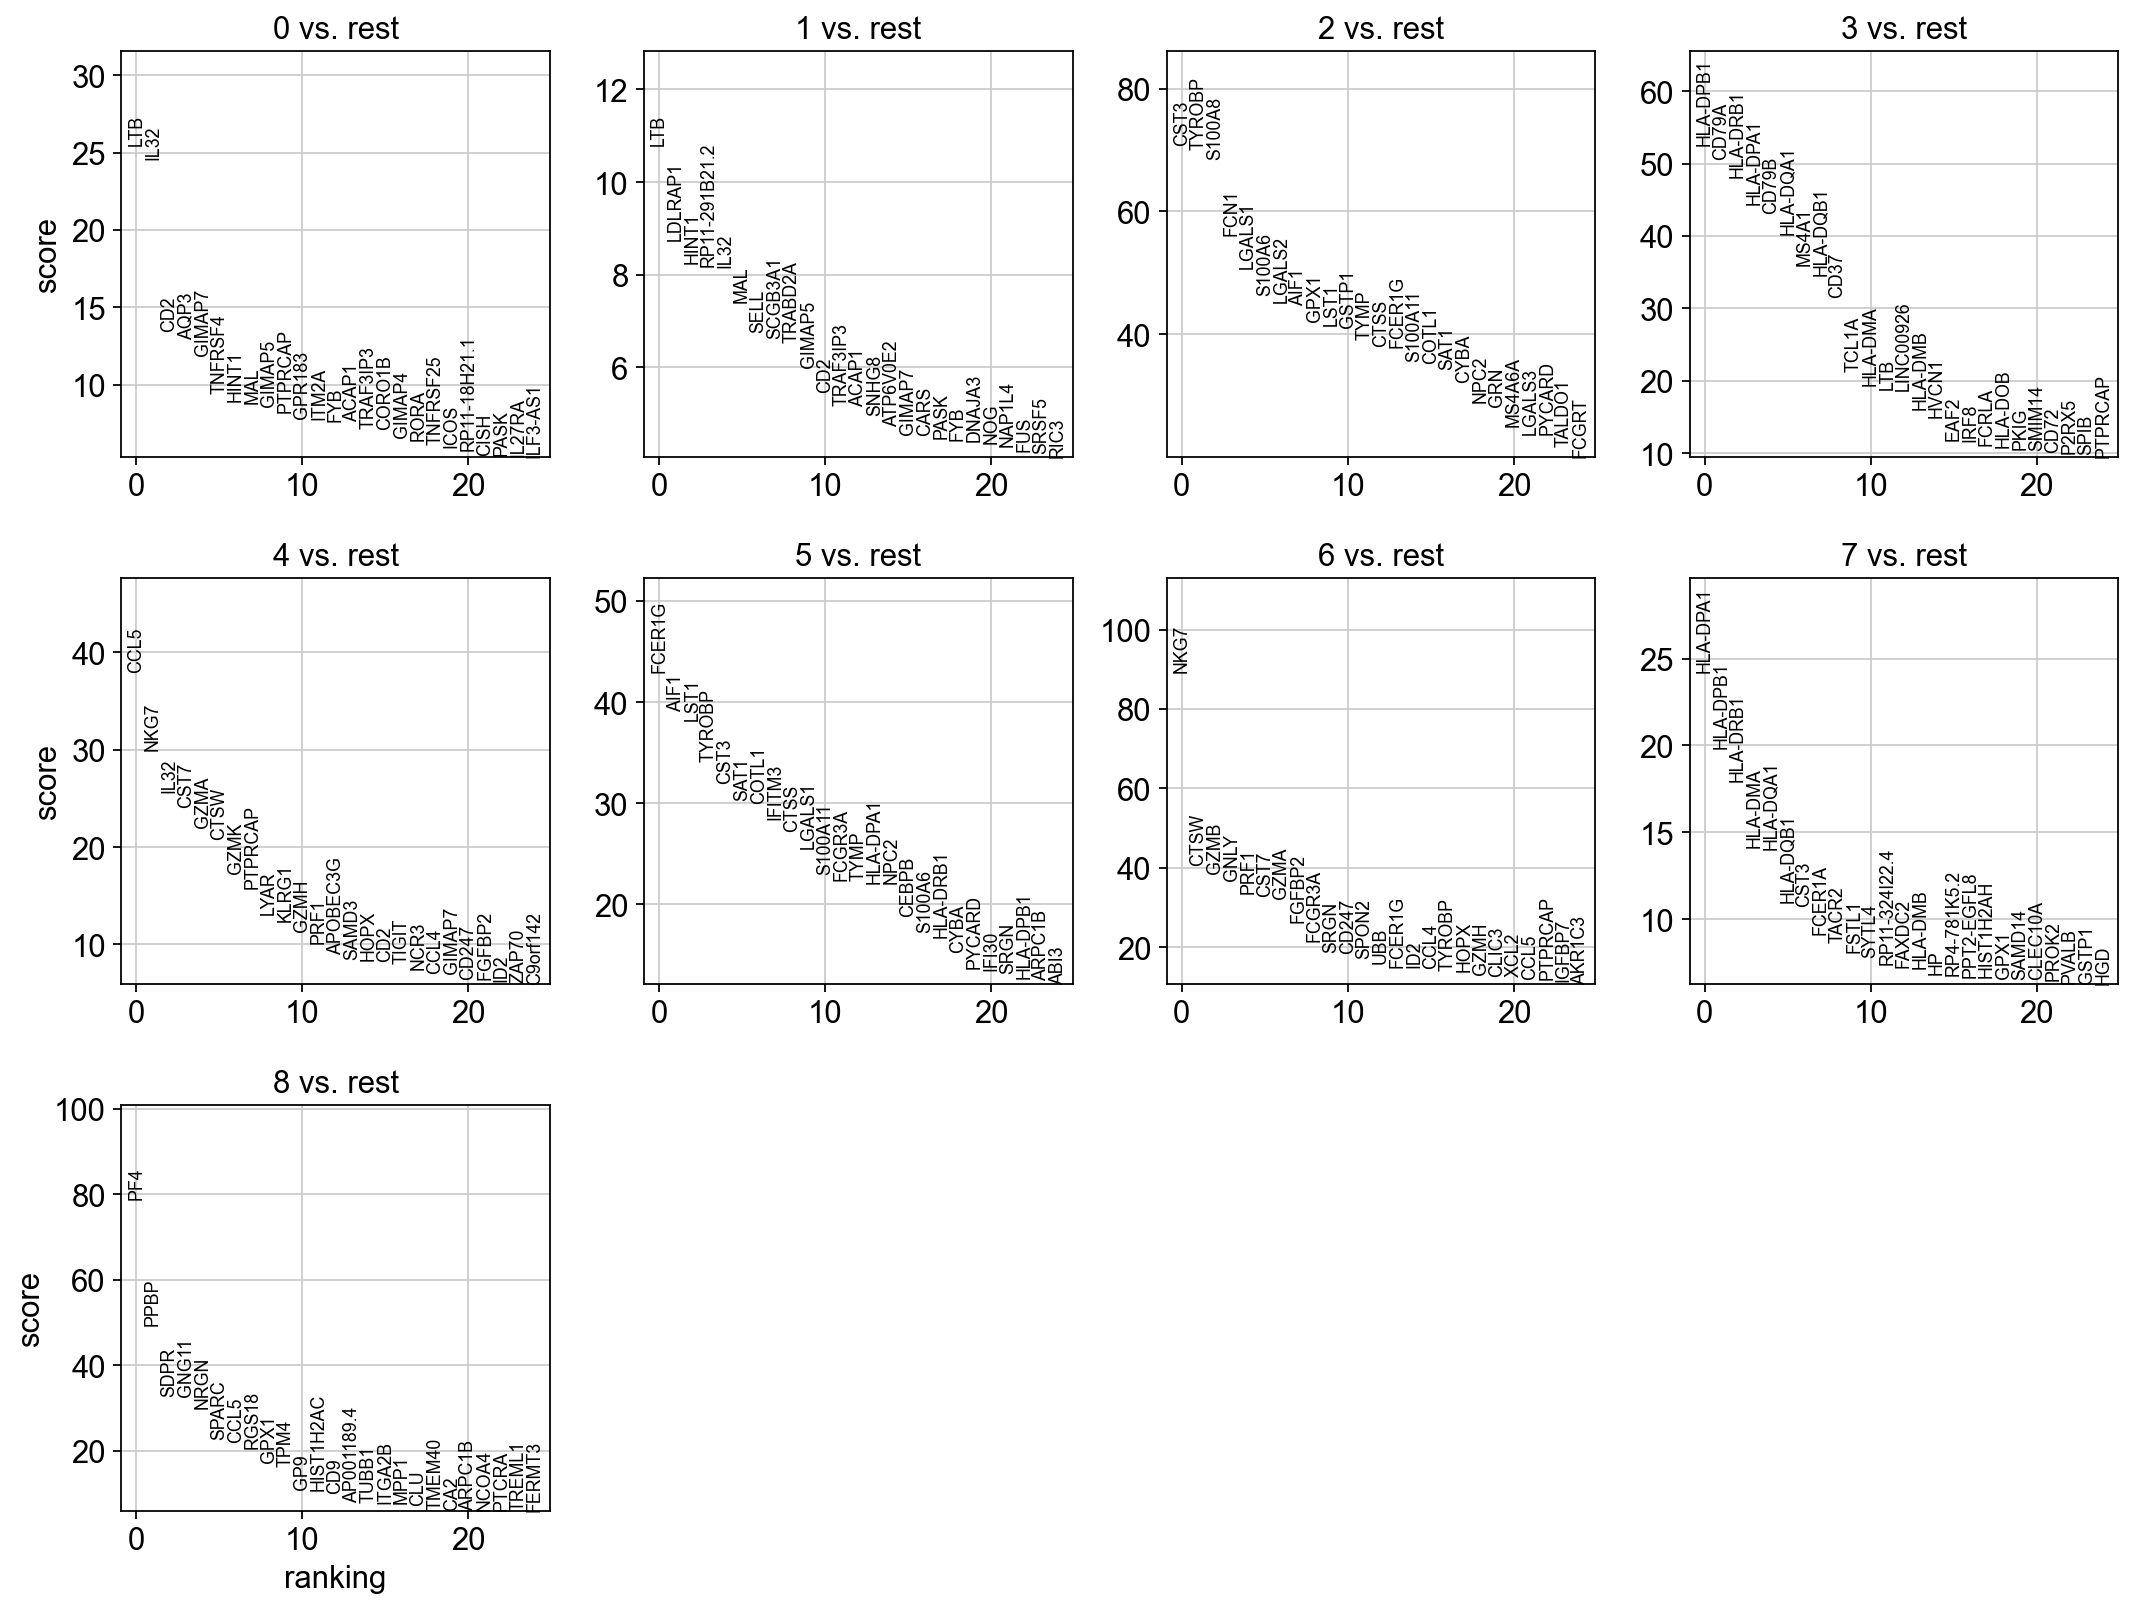

In [34]:
sc.tl.rank_genes_groups(adata, "leiden", method = "t-test")
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

In [35]:
sc.settings.verbosity = 2

ranking genes
    finished (0:00:00)


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: inv

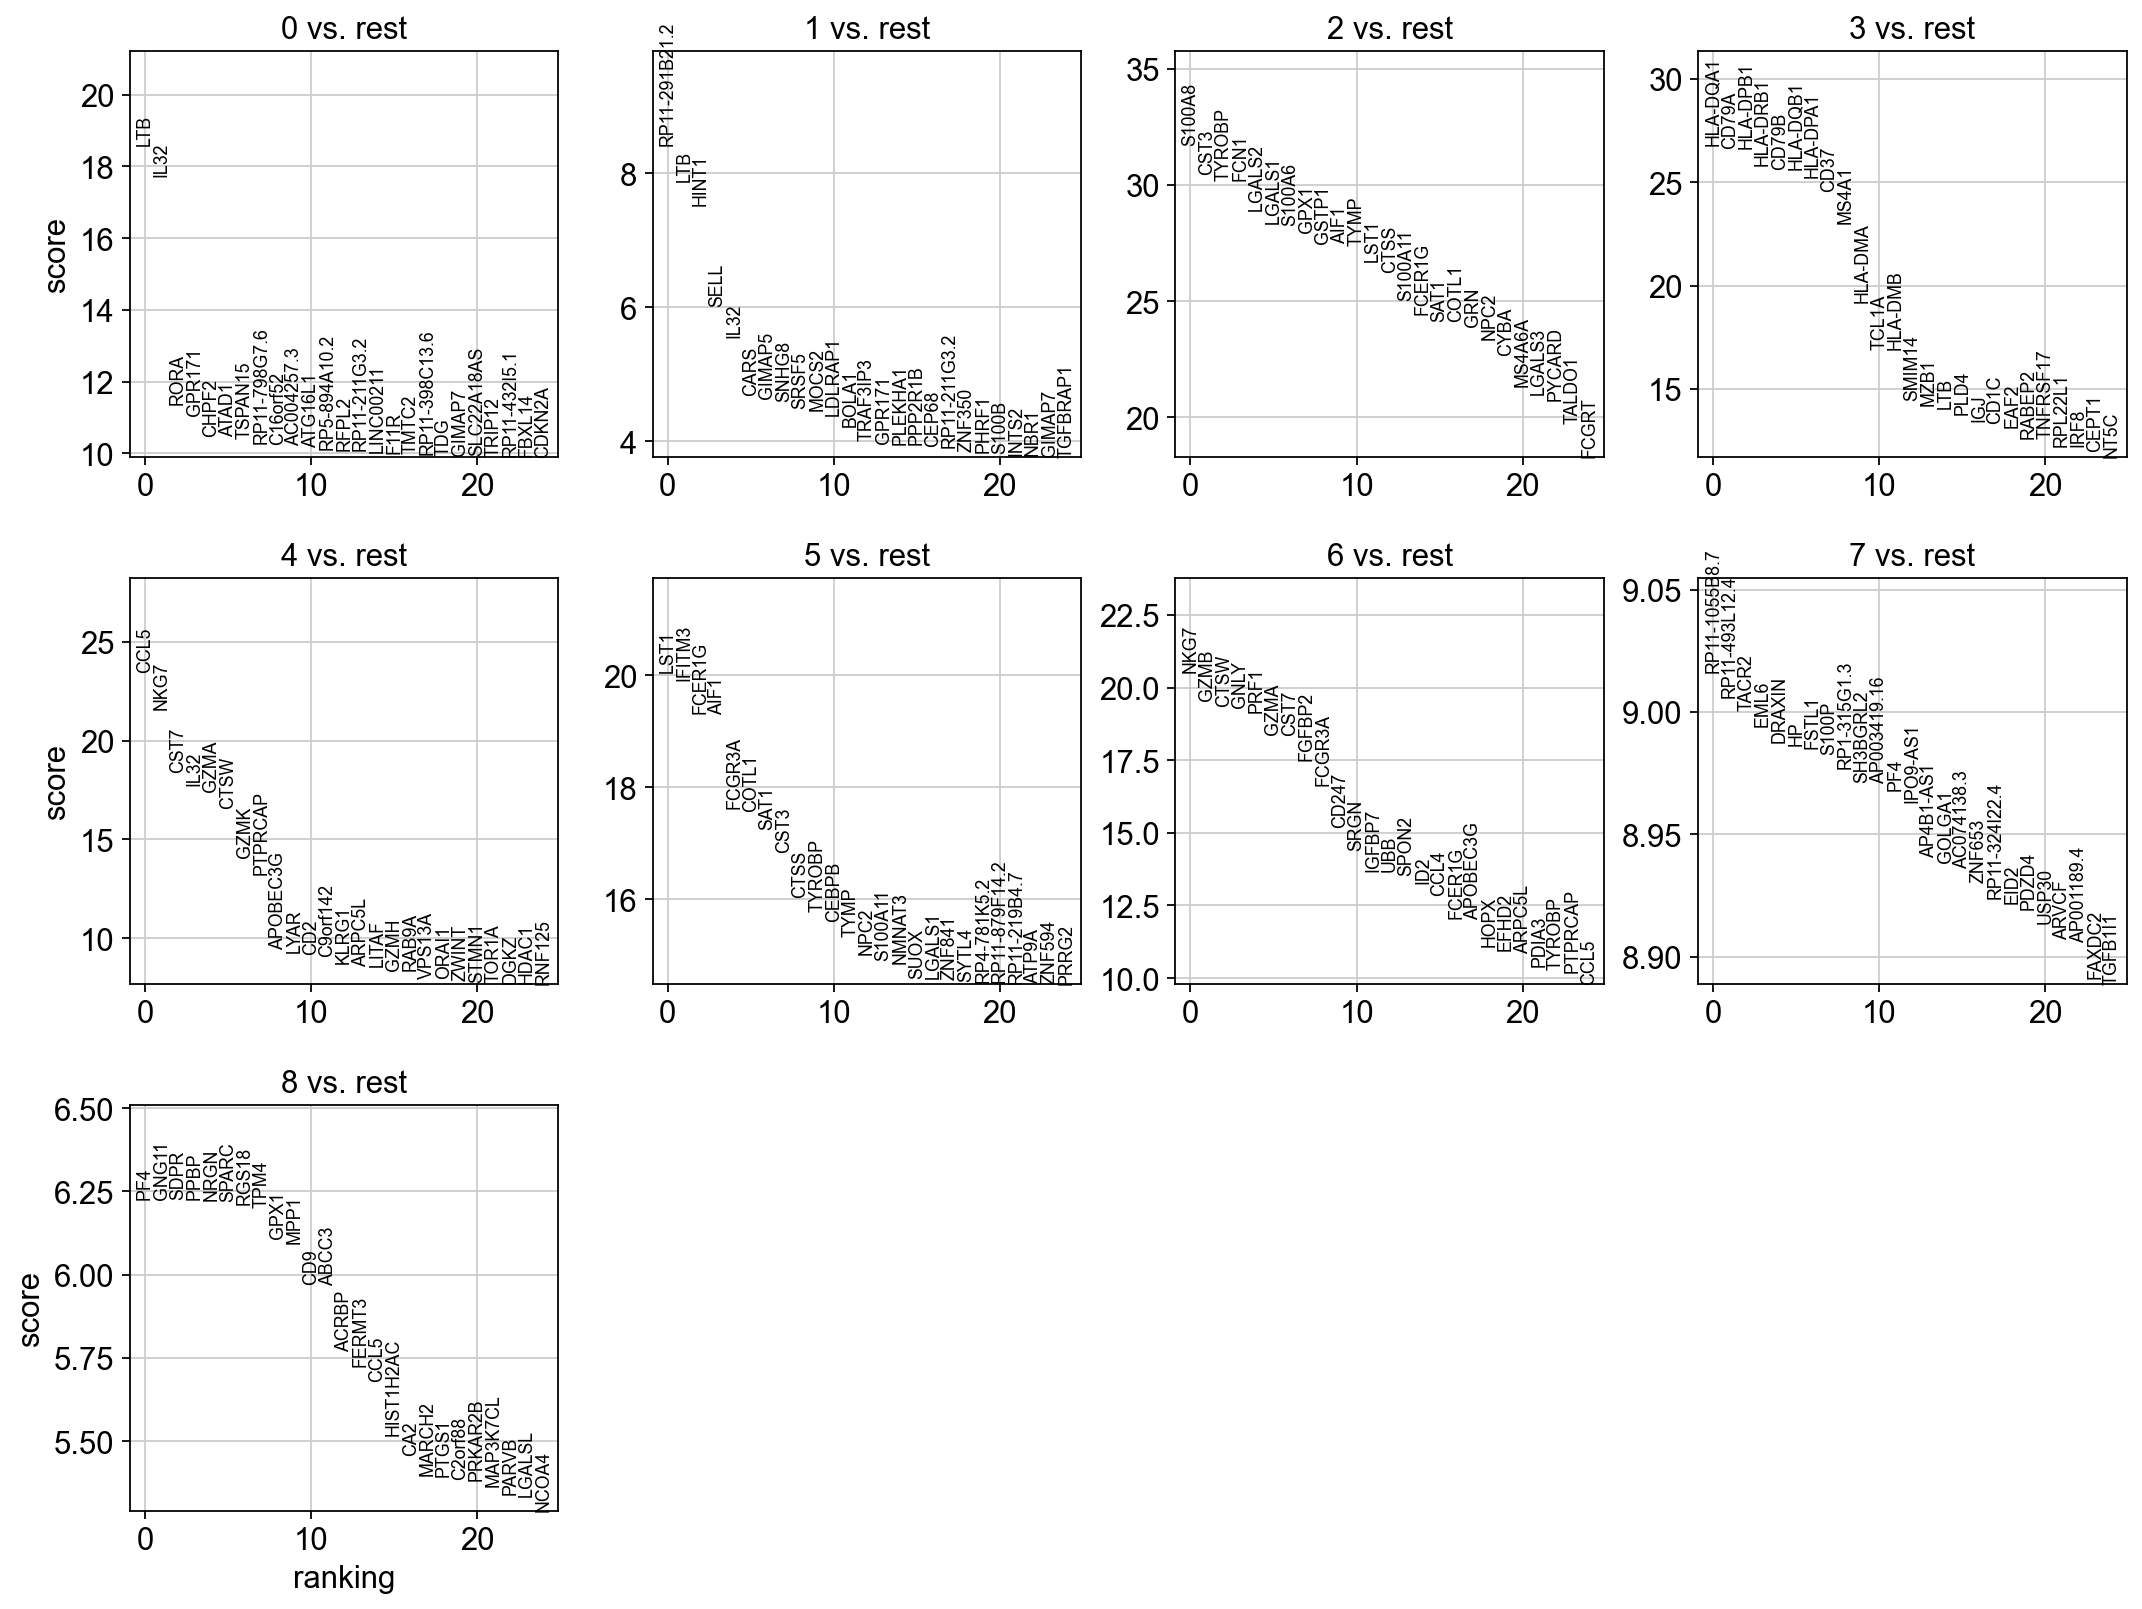

In [36]:
sc.tl.rank_genes_groups(adata, "leiden", method = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

In [37]:
adata.write(results_file)

ranking genes
    finished (0:00:00)


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: inv

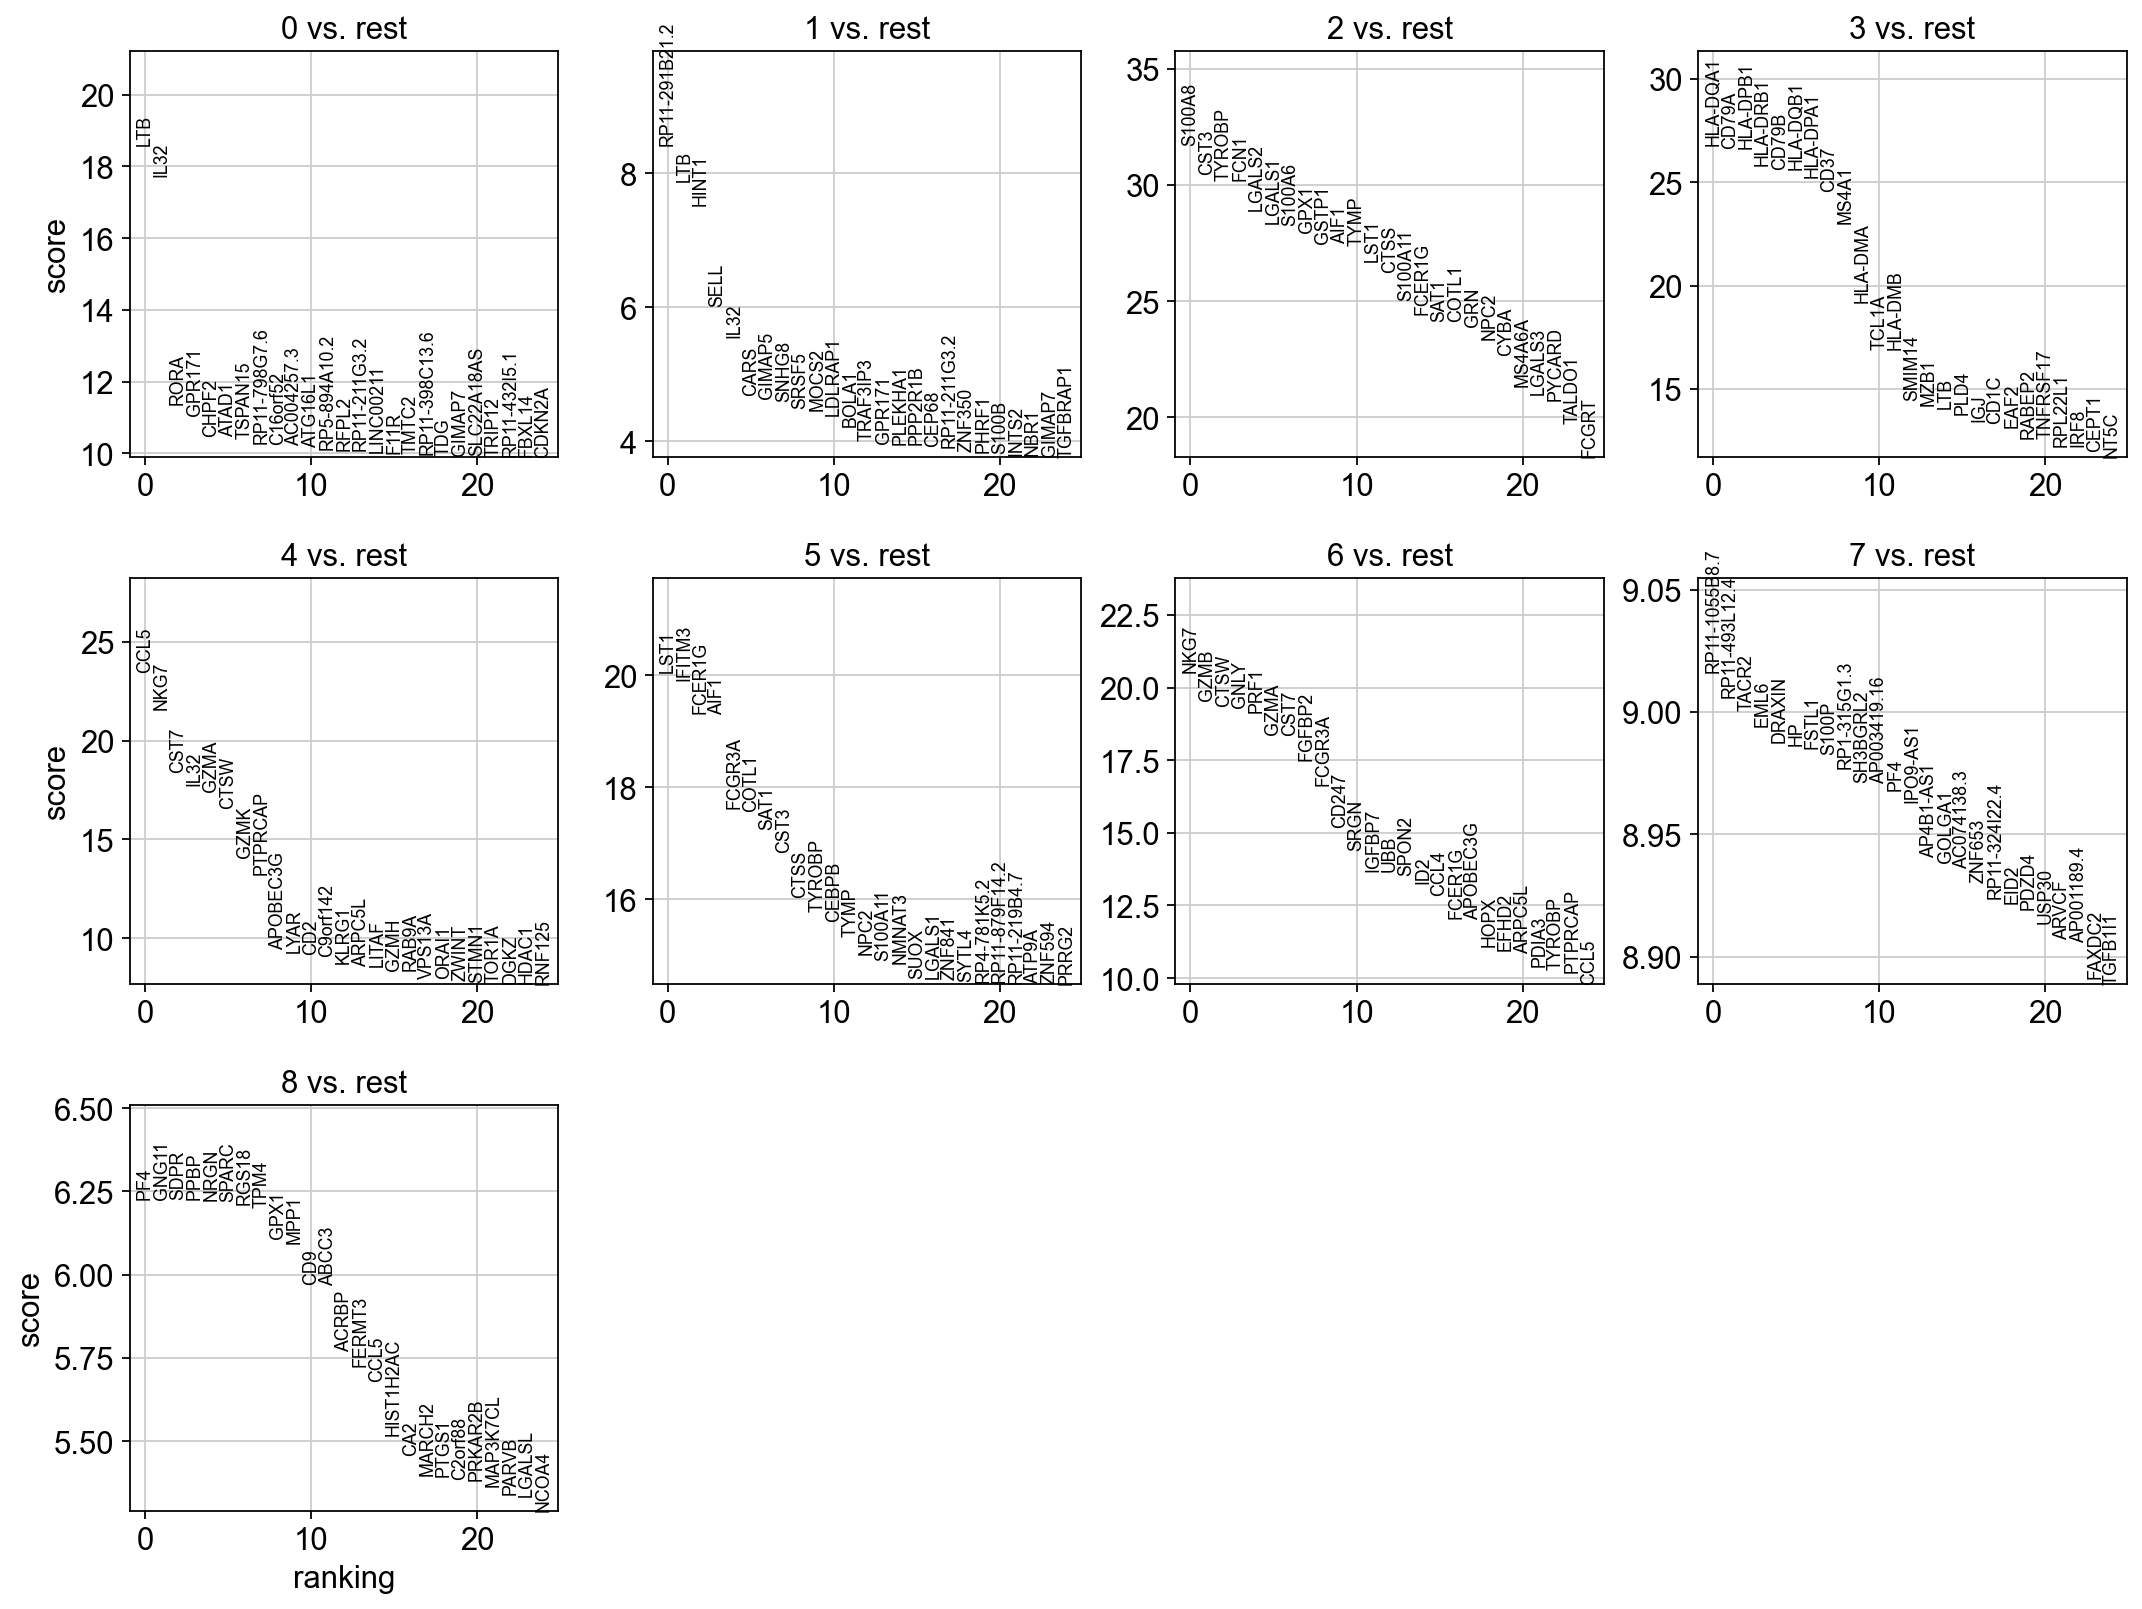

In [38]:
sc.tl.rank_genes_groups(adata, "leiden", method = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

In [39]:
marker_genes = ["CD79A", "MS4A1", "LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1", "FCGR3A", "FCER1A", "CST3", "PPBP"]

In [40]:
adata = sc.read(results_file)

In [41]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0              1       2         3     4       5     6              7  \
0     LTB  RP11-291B21.2  S100A8  HLA-DQA1  CCL5    LST1  NKG7  RP11-1055B8.7   
1    IL32            LTB    CST3     CD79A  NKG7  IFITM3  GZMB  RP11-493L12.4   
2    RORA          HINT1  TYROBP  HLA-DPB1  CST7  FCER1G  CTSW          TACR2   
3  GPR171           SELL    FCN1  HLA-DRB1  IL32    AIF1  GNLY           EML6   
4   CHPF2           IL32  LGALS2     CD79B  GZMA  FCGR3A  PRF1         DRAXIN   

       8  
0    PF4  
1  GNG11  
2   SDPR  
3   PPBP  
4   NRGN

In [42]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {group + "_" + key[:1]: result[key][group]
     for group in groups for key in ["names", "pvals"]}).head(5)

0_n           0_p            1_n           1_p     2_n            2_p  \
0     LTB  3.234600e-77  RP11-291B21.2  3.777929e-17  S100A8  7.776926e-221   
1    IL32  2.221225e-70            LTB  3.307598e-15    CST3  6.631019e-204   
2    RORA  5.439522e-30          HINT1  5.195510e-14  TYROBP  1.641608e-200   
3  GPR171  1.531700e-28           SELL  1.727438e-09    FCN1  3.313601e-200   
4   CHPF2  1.079645e-25           IL32  2.644750e-08  LGALS2  4.611816e-184   

        3_n            3_p   4_n            4_p     5_n           5_p   6_n  \
0  HLA-DQA1  2.979480e-158  CCL5  6.351922e-122    LST1  1.578975e-89  NKG7   
1     CD79A  1.658759e-156  NKG7  2.378129e-103  IFITM3  3.222792e-88  GZMB   
2  HLA-DPB1  1.699735e-156  CST7   1.086254e-75  FCER1G  3.177182e-83  CTSW   
3  HLA-DRB1  3.802586e-147  IL32   1.599987e-70    AIF1  4.910837e-83  GNLY   
4     CD79B  4.576998e-145  GZMA   2.511171e-68  FCGR3A  1.561947e-69  PRF1   

            6_p            7_n           7_p    8_n           8_p  
0  9.067974e-94  RP11-1055B8.7  1.943597e-19    PF4  4.722886e-10  
1  2.404541e-85  RP11-493L12.4  2.131805e-19  GNG11  4.733899e-10  
2  1.831829e-83          TACR2  2.241532e-19   SDPR  4.733899e-10  
3  2.391760e-83           EML6  2.375820e-19   PPBP  4.744938e-10  
4  9.592376e-82         DRAXIN  2.528165e-19   NRGN  4.800511e-10

In [43]:
sc.pp.log1p(adata)

/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


ranking genes
    finished (0:00:00)


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


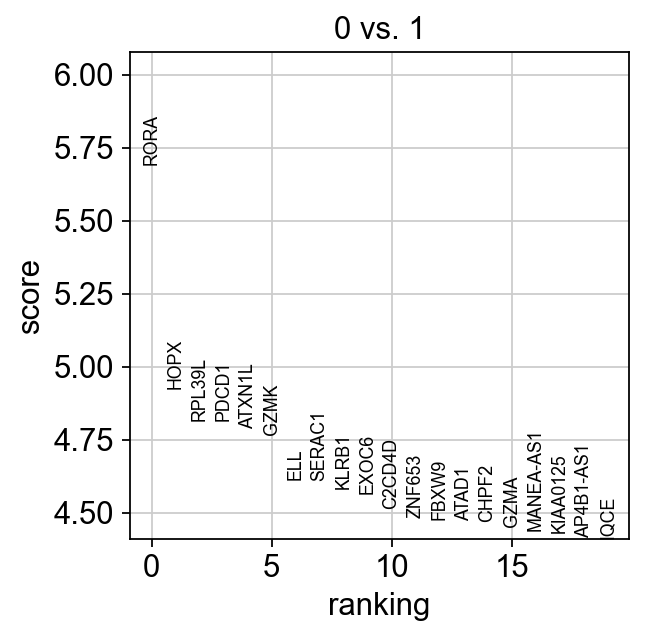

In [44]:
sc.tl.rank_genes_groups(adata, "leiden", groups = ["0"], reference = "1", method = "wilcoxon")
sc.pl.rank_genes_groups(adata, groups = ["0"], n_genes = 20)

/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


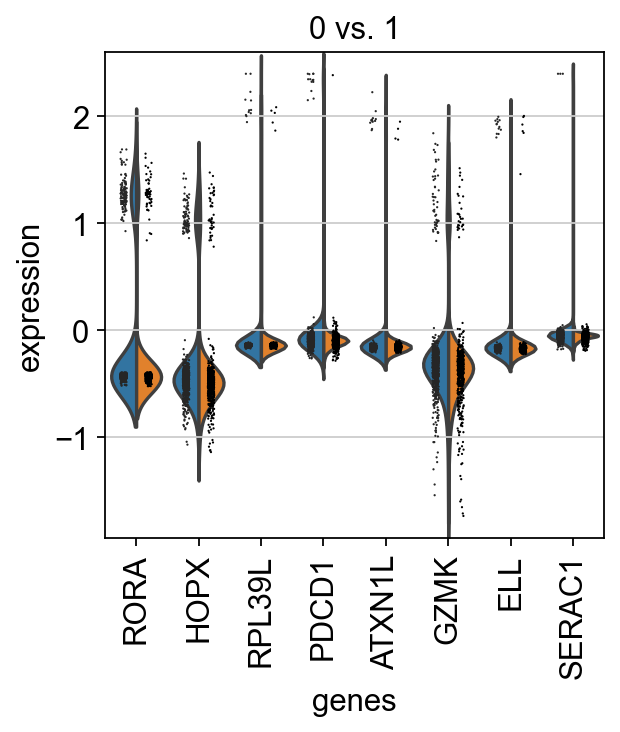

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups = "0", n_genes = 8)

In [46]:
adata = sc.read(results_file)

/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


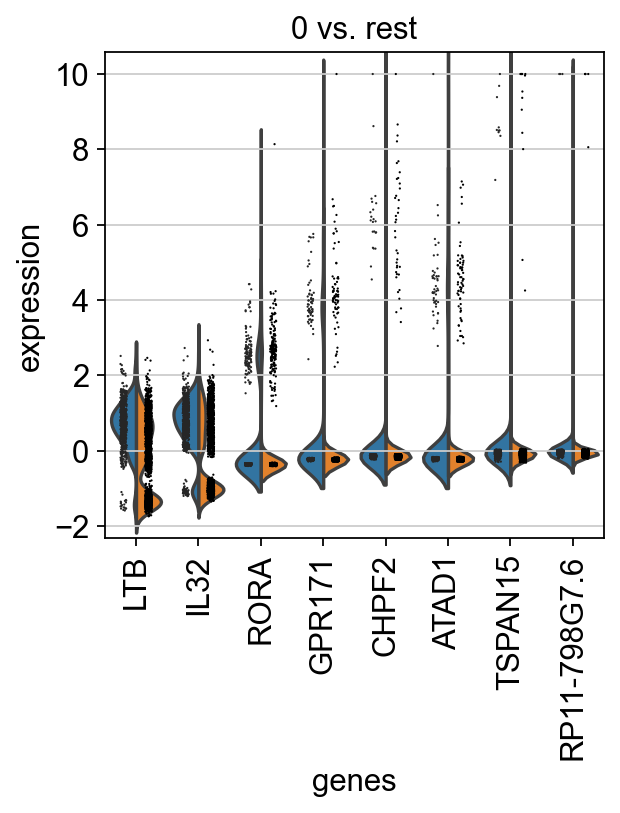

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups = "0", n_genes = 8)

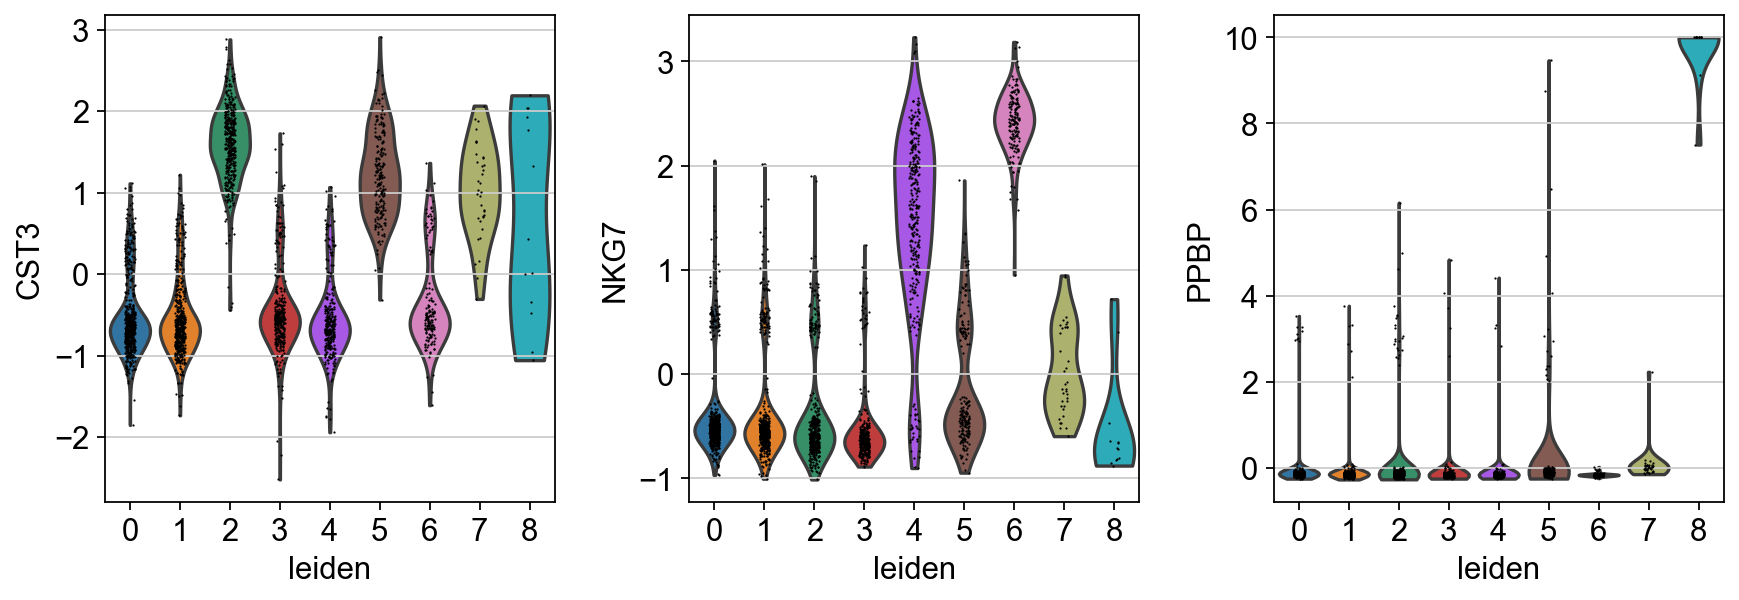

In [48]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby = "leiden")

In [49]:
new_cluster_names = [
    "CD4 T", "CD14 Monocytes", "B", "CD8 T", "NK", "FCGR3A Monocytes", "Dendritic", "Megakaryocytes", "x"]
adata.rename_categories("leiden", new_cluster_names)

/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


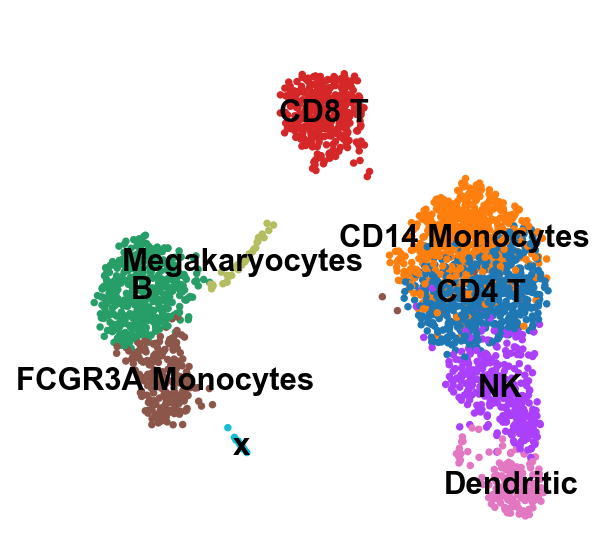

In [50]:
sc.pl.umap(adata, color = "leiden", legend_loc = "on data", title = " ", frameon = False, save = ".pdf")

/Users/workexperience/Documents/Project/venv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


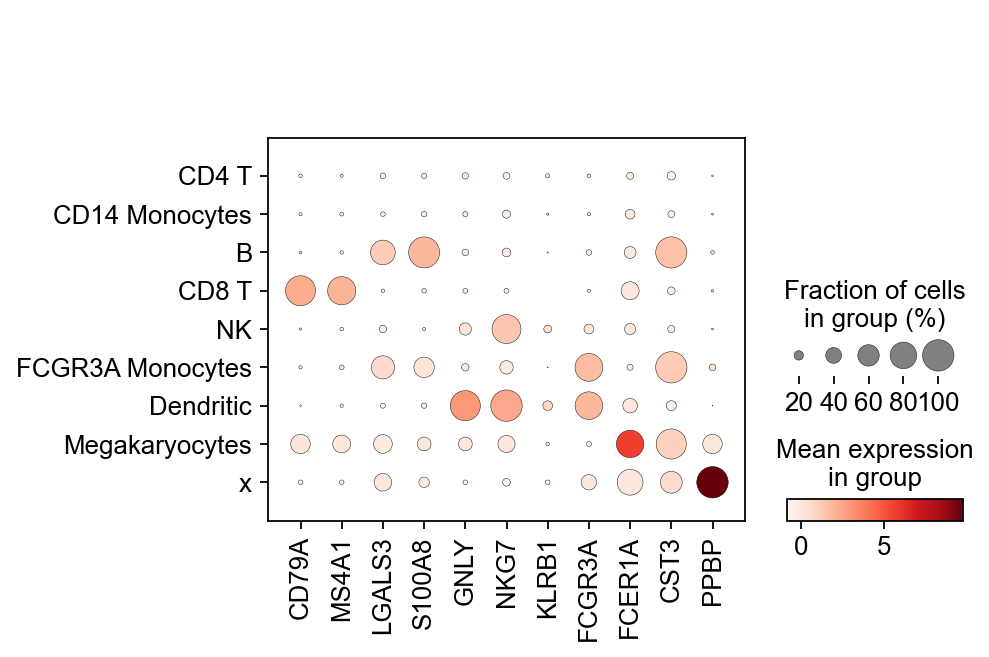

In [51]:
sc.pl.dotplot(adata, marker_genes, groupby = "leiden");

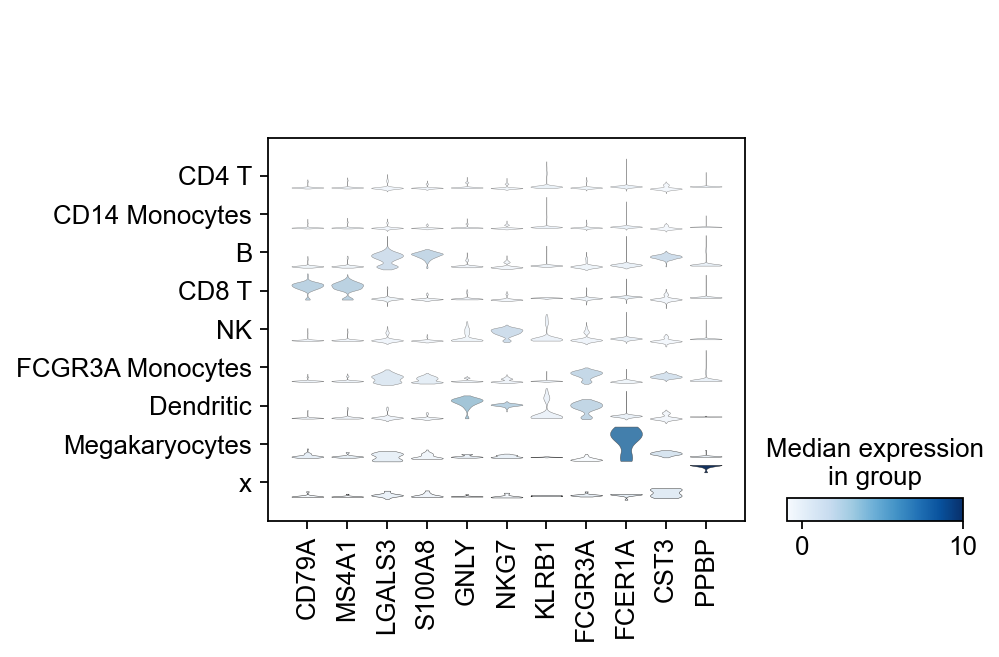

In [52]:
sc.pl.stacked_violin(adata, marker_genes, groupby = "leiden", rotation = 90);

In [53]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [54]:
adata.write(results_file, compression = "gzip")

In [55]:
adata.raw.to.adata().write("./write/pbmc3k_withoutX.h5ad")

AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
adata.var


## Trouble shooting:

if the code is having issues running, try out these steps:

* 1) double check all your syntax and variables 
* 2) check your files contain the same data
* 3) type these commands into the console to install these versions of the following softwares and re-run the program:

```bash
pip install numpy==1.21.6
pip install scipy==1.8.1
pip install pandas==1.5.0
pip install scikit-learn==1.1.2
pip install statsmodel==0.13.2
pip install statsmodels==0.13.2
pip install python-igraph==0.10.1
pip install pynndescent==0.5.7
```

